In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#%load_ext autotime
%load_ext autoreload
%autoreload 2
import os

This notebook is a companion to the paper TBC, and reproduces the plots from the paper. We use the Ginibre point process as a running example. It is convenient, since its two-point correlation function and structure factor are analytically known. We provide a sample in `../data`.

In [2]:
#loading data
import pickle
path_data = "../data"
with open(os.path.join(path_data, "ginibre_pp.dat"), "rb") as data:
    ginibre_pp = pickle.load(data, encoding="bytes")
points = ginibre_pp[0].points #ginibre point configuration

# Section 5.2

We use a preloaded sample from the Ginibre point process to instantiate an object of type `PointPattern` containing the points, the observation window (here a disk), and the intensity, since the latter is known to the user. When it is not known, the intensity is approximated by the number of points in the sample divided by the volumme of the window.

In [3]:
from hypton.point_pattern import PointPattern
from hypton.spatial_windows import BallWindow
import numpy as np
radius = 100  # radius of the disk containing "points"
center = [0, 0]  # center of the disk containing "points"
window = BallWindow(center, radius)  # create a ball window
intensity = 1/np.pi # known intensity of the Ginibre point process
ginibre_pp = PointPattern(points, window, intensity) #ginibre point pattern 

<AxesSubplot:>

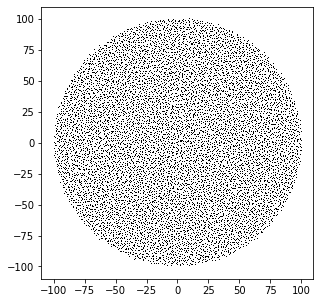

In [4]:
ginibre_pp.plot() # we provide a method to plot the underlying sample

Approximating structure factors can be done within the `StructureFactor` class, which takes a `PointPattern` as input.

In [5]:
from hypton.structure_factor import StructureFactor
sf_ginibre = StructureFactor(ginibre_pp) 

# Section 5.3


In this section, we compute and visualize the scattering intensity of the Ginibre configuration.
Note that the scattering intensity requires a **cubic window**, so that we start by restricting our Ginibre sample to a cubic window.

Restricting the window to a cube of length 70.71067811865474


<AxesSubplot:>

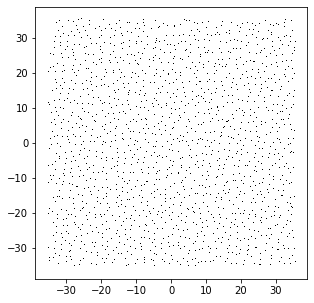

In [6]:
from hypton.spatial_windows import BoxWindow
L = radius/np.sqrt(2) # sidelength of the cubic window
print("Restricting the window to a cube of length", L)
bounds = np.array([[-L/2, -L/2], [L/2, L/2]]) 
window = BoxWindow(bounds) # create a cubic window
ginibre_pp_box = ginibre_pp.restrict_to_window(window) # create a Ginibre point pattern with box window
sf_ginibre_box = StructureFactor(ginibre_pp_box) # initialize a new instance of StructureFactor
ginibre_pp_box.plot()

We now compute the scattering intensity of the point pattern ginibre_pp_box, on a mehsgrid of allowed wavevalues with maximun wavelength equal to 6, and meshgrid size equal to 100. See paper for an explanation of the concept of *allowed values*.

In [7]:
norm_k, si = sf_ginibre_box.compute_sf_scattering_intensity(
                                    max_k=6, 
                                    meshgrid_size=100,
                                    )

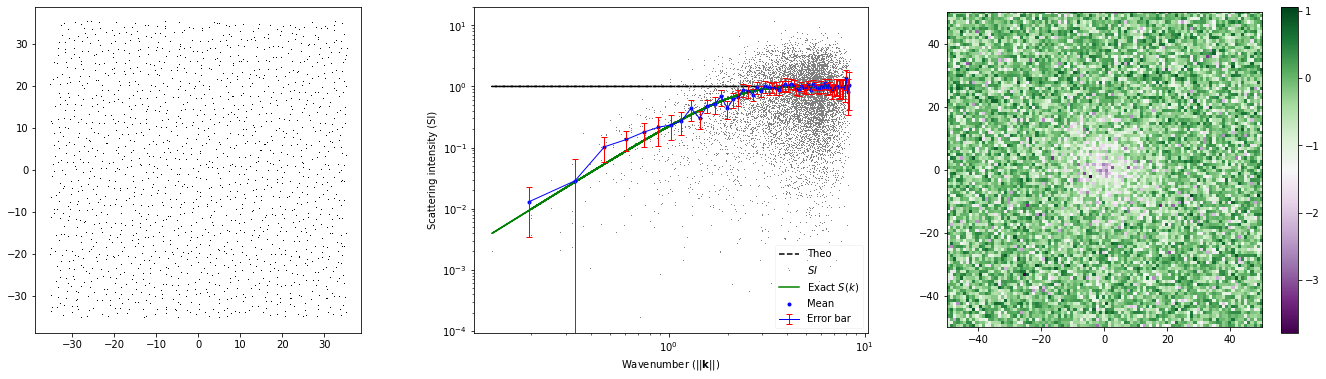

In [8]:
# plot the scattering intensity and compare it to its exact value
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4)
fig = sf_ginibre_box.plot_scattering_intensity(norm_k, si, plot_type="all",
                                            exact_sf=exact_sf_ginibre,
                                            bins=60, # number of bins
                                            error_bar=True, # visualizing the error bars
                                            file_name="si_ginibre.pdf"
                                              )

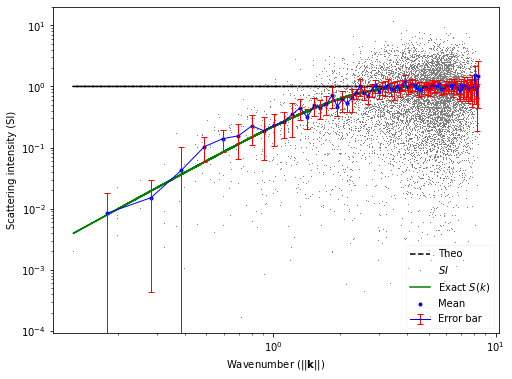

In [9]:
# we can also extract the radial plot
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) #exact sf
fig = sf_ginibre_box.plot_scattering_intensity(norm_k, si, plot_type="plot",
                                            exact_sf=exact_sf_ginibre,
                                            bins=80, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

The blue line connect the within-bin averages of $\hat S(\mathbf k)$, while the red error bars correspond to plus or minus one standard deviation (before taking the log). The blue approximation is a good fit to the theoretical structure factor in green.

By default, the scattering intensity is evaluated at allowed wavevectors (aka the dual lattice to the observation window). However, we also accomodate evaluations at arbitrary points. Here, we demonstrate this using an arbitrary meshgrid of non-allowed wave vectors. 

In [10]:
x = np.linspace(-3, 3, 200)
x = x[x != 0]
X, Y = np.meshgrid(x, x)
k_vector1 = [X,Y]
norm_k1, si1 = sf_ginibre_box.compute_sf_scattering_intensity(
                                    k_vector=k_vector1, 
                                    )

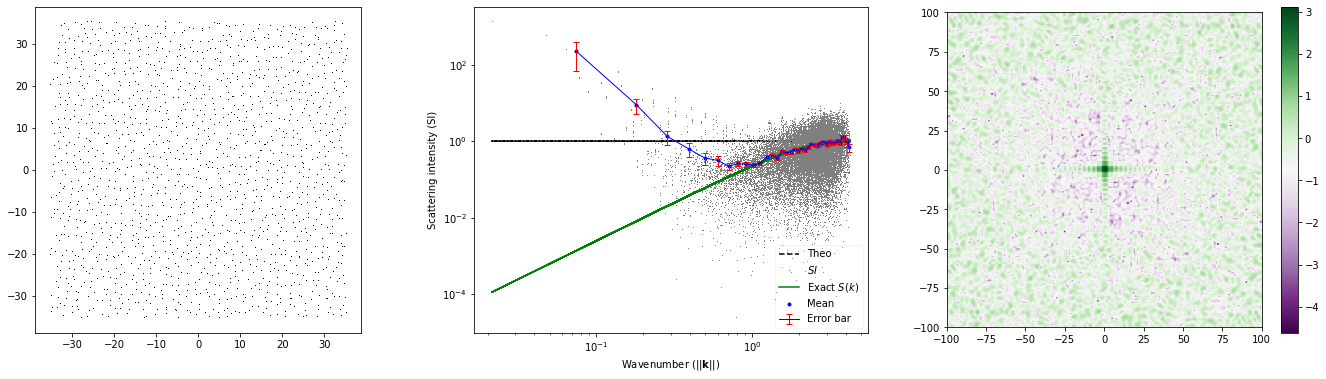

In [11]:
# plot the scattering intensity and compare it to its exact value
fig = sf_ginibre_box.plot_scattering_intensity(norm_k1, si1, plot_type="all",
                                            exact_sf=exact_sf_ginibre,
                                            bins=40, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

As expected from the derivation of the scattering intensity in the paper, using non-allowed values augments the number of evaluations and thus reduces the uncertainty for large values of $\Vert \mathbf k\Vert$, but introduces a large bias for, say, $\Vert \mathbf k\Vert\leq 1$.

Calling the scattering intensity on a non-cubic window will also result in additional bias. We raise a `Warning`, but the computation will proceed. For instance, let us see what happens if we use the initial ball window for our Ginibre point process.

In [12]:
from hypton import utils
k_vector2 = utils.allowed_wave_values(L=radius, max_k=6, meshgrid_size=200)
k_vector2 = [k_vector2[:,0], k_vector2[:,1]] #transforming k_vector to list
norm_k2, si2 = sf_ginibre.compute_sf_scattering_intensity(
                                    k_vector=k_vector2
                                    )


/Users/dhawat/github/structure-factor/src/hypton/structure_factor.py:101: UserWarning: The window should be a BoxWindow for that the scattering intensity consists an approximation of the structure factor. Hint: use PointPattern.restrict_to_window.
  warnings.warn(


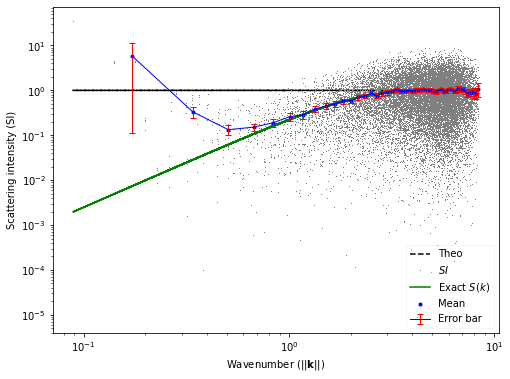

In [13]:
fig_3 = sf_ginibre.plot_scattering_intensity(norm_k2, si2, plot_type="plot",
                                            exact_sf=exact_sf_ginibre,
                                            bins=50, error_bar=True,
                                            #file_name="si_ginibre.pdf"
                                              )

Again, there is serius overestimation for $\Vert \mathbf k\Vert \leq 1$. 

To conclude, and to insist on the role of *allowed* wavevectors for the scattering intensity at small $\Vert \mathbf k\Vert$, we plot all three estimates on the same figure. 

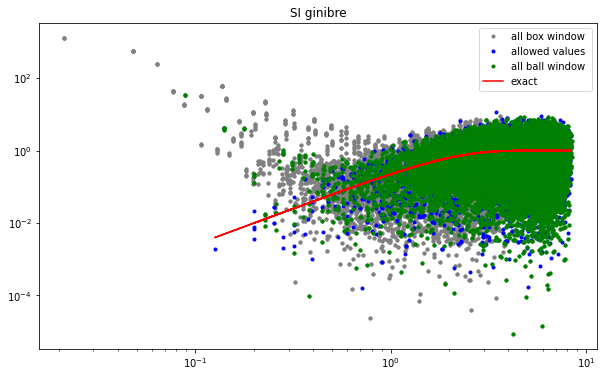

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.loglog(norm_k1.ravel(), si1.ravel(), color="grey",linestyle="", marker=".", label="all box window ")
plt.loglog(norm_k.ravel(), si.ravel(), 'b.', label="allowed values")
plt.loglog(norm_k2.ravel(), si2.ravel(), 'g.', label="all ball window ")
plt.loglog(norm_k.ravel(), exact_sf_ginibre(norm_k.ravel()), 'r', label="exact")
plt.legend()
plt.title("SI ginibre")
plt.show()

# section 5.6

## Test of effective hyperuniformity

In [15]:
type(si)

numpy.ndarray

In [16]:
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, si)
hyperuniformity_test.bin_data(bins=100)
H_ginibre, std = hyperuniformity_test.index_H(norm_k_stop=4)
print("H_ginibre=", H_ginibre)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
index_peak = hyperuniformity_test.i_first_peak

H_ginibre= -0.04857880635988946


As $H <10^{-3}$ so the test success to predict the hyperuniformity of the Ginibre ensemble.

The bellow plot show the fitted regression line used to find the H index 

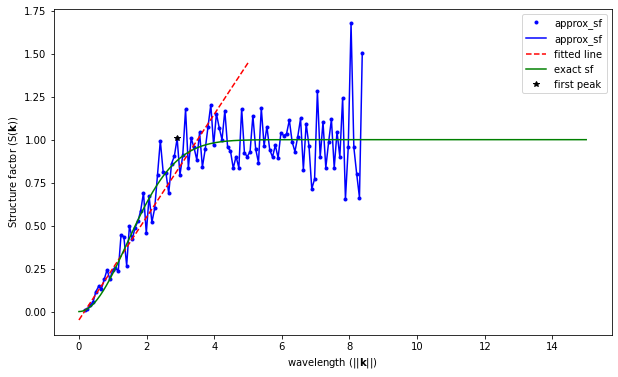

In [17]:
import matplotlib.pyplot as plt
mean_norm_k = hyperuniformity_test.norm_k
mean_sf = hyperuniformity_test.sf
x = np.linspace(0, 5, 300)
y = np.linspace(0,15, 500)
fig=plt.figure(figsize=(10,6))
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(mean_norm_k, mean_sf, 'b', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.plot(y, exact_sf_ginibre(y), 'g', label="exact sf")
plt.plot(mean_norm_k[index_peak], mean_sf[index_peak], 'k*', label="first peak")
plt.legend()
plt.xlabel('wavelength ($||\mathbf{k}||$)')
plt.ylabel('Structure factor ($\mathsf{S}(\mathbf{k})$)')
plt.show()
fig.savefig("fitted_si_ginibre.pdf", bbox_inches="tight")

In [33]:
hyperuniformity_test = EffectiveHyperuniformity(norm_k, si)
hyperuniformity_test.bin_data(bins=80)
sf_power_decay, S_0 = hyperuniformity_test.power_decay(norm_k_stop=0.8)
print(sf_power_decay, S_0)

3.9520941438310206 0.00844236914555739


In [ ]:
import matplotlib.pyplot as plt
mean_norm_k = hyperuniformity_test.norm_k
mean_sf = hyperuniformity_test.sf
x = np.linspace(0, 5, 300)
y = np.linspace(0,15, 500)
fig=plt.figure(figsize=(10,6))
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(mean_norm_k, mean_sf, 'b', label="approx_sf")
plt.plot(y, exact_sf_ginibre(y), 'g', label="exact sf")
plt.legend()
plt.xlabel('wavelength ($||\mathbf{k}||$)')
plt.ylabel('Structure factor ($\mathsf{S}(\mathbf{k})$)')
plt.show()
fig.savefig("fitted_si_ginibre.pdf", bbox_inches="tight")

In [21]:
from hypton.effective_hyperuniform import EffectiveHyperuniformity
norm_k2 = np.linspace(0,10, 100)
sf2 = exact_sf_ginibre(norm_k2)
hp_test2 = EffectiveHyperuniformity(norm_k2, sf2)
H_ginibre2, std2 = hp_test2.index_H(norm_k_stop=4)
print("H_ginibre2=", H_ginibre2)
fitted_sf_line2 = hp_test2.fitted_line # fittend ligne
index_peak2 = hp_test2.i_first_peak

H_ginibre2= -0.027173123442916225


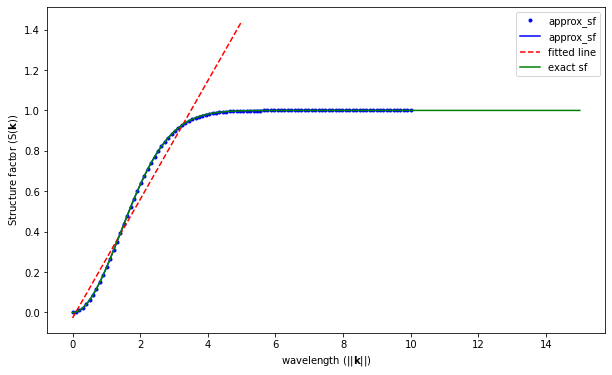

In [20]:
mean_norm_k2 = hp_test2.norm_k
mean_sf2 = hp_test2.sf
x = np.linspace(0, 5, 300)
y = np.linspace(0,15, 500)
fig=plt.figure(figsize=(10,6))
plt.plot(mean_norm_k2, mean_sf2, 'b.', label="approx_sf")
plt.plot(mean_norm_k2, mean_sf2, 'b', label="approx_sf")
plt.plot(x, fitted_sf_line2(x), 'r--', label= "fitted line")
plt.plot(y, exact_sf_ginibre(y), 'g', label="exact sf")
#plt.plot(mean_norm_k2[index_peak2], mean_sf2[index_peak2], 'k*', label="first peak")
plt.legend()
plt.xlabel('wavelength ($||\mathbf{k}||$)')
plt.ylabel('Structure factor ($\mathsf{S}(\mathbf{k})$)')
plt.show()
fig.savefig("fitted_si_ginibre.pdf", bbox_inches="tight")

# Section 5.4

In this section we will approximate the pair correlation function of the Ginibre ensemble using two methods: pcf.ppp and pcf.fv

In [ ]:
r= np.linspace(0, 30, 500)
pcf_ppp = sf_ginibre.compute_pcf(method="ppp", r=r,
                                        correction="all")
pcf_ppp

In [ ]:
exact_pcf_ginibre = lambda x : 1 - np.exp(-x**2) # exact pcf of the Ginibre ensemble
fig = sf_ginibre.plot_pcf(pcf_ppp, exact_pcf=exact_pcf_ginibre,
                    file_name="pcf_ppp_ginibre.pdf",
                    figsize=(10,6))

In [ ]:
pcf_fv = sf_ginibre.compute_pcf(method="fv", Kest=dict(rmax=45),
                                        fv=dict(method="b", spar=0.1))
pcf_fv

In [ ]:
fig = sf_ginibre.plot_pcf(pcf_fv, exact_pcf=exact_pcf_ginibre,
                    file_name="pcf_fv_ginibre.pdf",
                    figsize=(10,6))

## section 5.5

In this section we approximate the structure factor of the Ginibre ensemble using the Hankel transform approximated by Ogata quadrature
and the Discret Hankel trabsform derived by Baddour and Chouinard.
Before going through the approximation method, we interpolate the discrete sample of the approximated pcf.

In [ ]:
# interpolation of the approximated pair correlation function
domain, pcf_fv_func = sf_ginibre.interpolate_pcf(
        r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], 
        clean=True # removing nan and inf 
        )

In [ ]:
rmax = domain["rmax"] # upper bound of the raduis on which the pcf has been approximated
norm_k = np.linspace(1.5,10, 1000) # vector of wave length
norm_k, sf_Ogata = sf_ginibre.compute_sf_hankel_quadrature(pcf_fv_func,
                                                        norm_k=norm_k, 
                                                        step_size=0.1,
                                                        nb_points=1000,
                                                        rmax=rmax)
norm_k_min = sf_ginibre.norm_k_min
print("norm_k_min=", norm_k_min)

In [ ]:
fig = sf_ginibre.plot_sf_hankel_quadrature(norm_k, sf_Ogata, error_bar=True,
                             norm_k_min=norm_k_min, bins=40,
                             exact_sf=exact_sf_ginibre,
                             file_name="sf_ginibre_Ogata.pdf"
                                          )

In [ ]:
rmax = domain["rmax"]
norm_k = np.linspace(0.3,30, 2000)
norm_k, sf_BadChou = sf_ginibre.compute_sf_hankel_quadrature(pcf_fv_func, 
                                                            method ="BaddourChouinard",
                                                            norm_k=norm_k,
                                                            rmax=rmax, 
                                                            nb_points=1000)

fig = sf_ginibre.plot_sf_hankel_quadrature(norm_k, sf_BadChou,
                                    exact_sf=exact_sf_ginibre, 
                                           file_name="sf_baddchou.pdf",
                                          error_bar=True,
                                          bins=100)

In [ ]:
norm_k_, sf_BadChou_ = sf_ginibre.compute_sf_hankel_quadrature(pcf_fv_func, 
                                                            method ="BaddourChouinard",
                                                            rmax=rmax, 
                                                            nb_points=1000)

fig = sf_ginibre.plot_sf_hankel_quadrature(norm_k_, sf_BadChou_,
                                            exact_sf=exact_sf_ginibre, 
                                           #file_name="sf_baddchou.pdf",
                                          error_bar=True,
                                          bins=50)

In [ ]:
np.min(norm_k_)

## section 6.1

In this section we repet the experiance of the previous section but with a sample from the exact pair correlation function instead of the approximated one.
The goal is to see the influence of the error of approximating the pair correlation function on the result.

In [ ]:
# Method of Ogata:
norm_k = np.linspace(0.5,10, 1000)
r = pcf_fv["r"]
pcf_r = exact_pcf_ginibre(r)
domain, pcf_func = sf_ginibre.interpolate_pcf(r=r, pcf_r=pcf_r, clean=True) #interpolation
rmax = domain["rmax"]
norm_k, sf_Ogata = sf_ginibre.compute_sf_hankel_quadrature(pcf_func, norm_k=norm_k,
                                                rmax=rmax,
                                                step_size=0.01,
                                                nb_points=1000) 

fig = sf_ginibre.plot_sf_hankel_quadrature(norm_k, sf_Ogata, 
                             exact_sf=exact_sf_ginibre, 
                             file_name="sf_ogata_from_exact.pdf"
                                          )


In [ ]:
# Method of Baddour and Chouinard
norm_k, sf_BaddChou = sf_ginibre.compute_sf_hankel_quadrature(pcf_func, 
                                            method="BaddourChouinard",
                                            rmax=rmax, 
                                            nb_points=800) 

fig = sf_ginibre.plot_sf_hankel_quadrature(norm_k, sf_BaddChou, exact_sf=exact_sf_ginibre, 
                                           file_name="sf_baddchou_from_exact.pdf"
                                          )

We could deduce from the above figure that by minimizing the error of approximation of the pair correlation function we are able to approach the exact structure factor of the Ginibre ensemble.
Moreover using the Discret Hankel transform we reach the exact values of the structure factor.

# Section 6.3

In this section we repeat the previous experience on a point configuration from a standard homogeneous Poisson Point Process and KLY matching in a cubic window

## Poisson point process

In this section we repeat the previous experience on a point configuration from a standard homogeneous Poisson Point Process in a cubic window

In [34]:
# loading the point configuration as an object of type point pattern
with open(os.path.join(path_data, "poisson_pp.dat"), "rb") as data:
    poisson_pp = pickle.load(data, encoding="bytes")
poisson_pp = poisson_pp[0]
sf_poisson = StructureFactor(poisson_pp) # initializing the StructureFactor class

In [35]:
poisson_pp.points.shape

(90051, 2)

In [36]:
# compute the scattering intensity on a meshgrid of allowed values
norm_k, si = sf_poisson.compute_sf_scattering_intensity(max_k=10, meshgrid_size=90)

As the point congfiguration contains more than $10^5$ points we restrict the plot of the configuration to a small window.

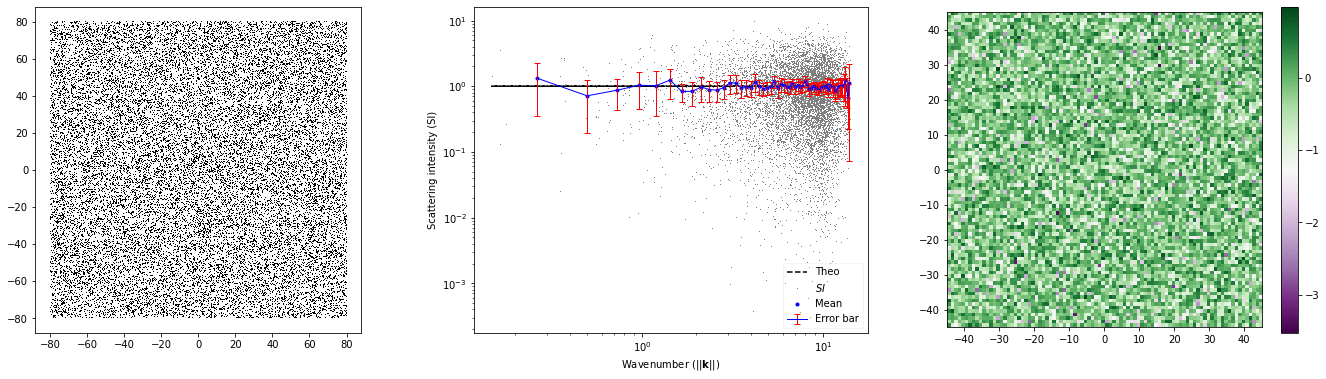

In [37]:
# visualizing the result
L=160
bounds = np.array([[-L/2, -L/2], [L/2, L/2]]) # bounds of the window 
window_res = BoxWindow(bounds) # window of visualization of the point config
fig = sf_poisson.plot_scattering_intensity(norm_k, si, plot_type="all",
                                            bins=60, error_bar=True,
                                            file_name="si_poisson.pdf", 
                                           window_res=window_res # restrict the plot of the point config to the window `window_res`
                                          )

We can deduce that also in this case the scattering intansity give a good approximation of the structure factor.

In [38]:
# test of effective hyperuniformity
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, si)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=60)
H_poisson, std_H_poisson = hyperuniformity_test.index_H( norm_k_stop=16)
print("H=", H_poisson, "std", std_H_poisson)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne

H= 0.9602092194152976 std 0.03164285962080776


Or $|H +/- std| > 10^{-3}$
Thus H index succesflly predict that the Poisson Point process in not hyperuniform

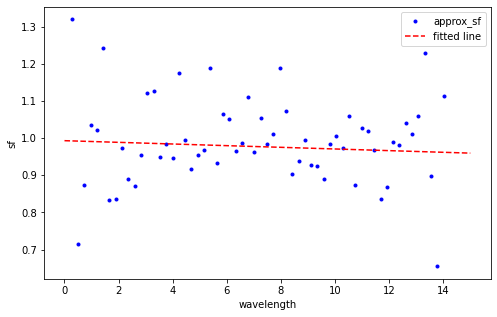

In [39]:
# plot fitted regression line used to find the H index
import matplotlib.pyplot as plt
x = np.linspace(0, 15, 300)
fig=plt.figure(figsize=(8,5))
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
fig.savefig("fitted_si_poisson.pdf", bbox_inches="tight")

In [44]:
hyperuniformity_test = EffectiveHyperuniformity(norm_k, si)
hyperuniformity_test.bin_data(bins=40)
sf_power_decay, S_0 = hyperuniformity_test.power_decay(norm_k_stop=0.)
print(sf_power_decay, S_0)

59.26800615748444 0.8504459266117249


/Users/dhawat/github/structure-factor/.venv/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
# approximating the pair correlation function
pcf_fv = sf_poisson.compute_pcf(method="fv", Kest=dict(rmax=100),
                                        fv=dict(method="b", spar=0.1))
pcf_fv

In [ ]:
# approximating the stracture factr using Ogata quadrature 
domain, pcf_fv_func = sf_poisson.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True) # interpolation of pcf_fv
rmax = domain["rmax"]
norm_k = np.linspace(2,30, 1000)
norm_k, sf_Ogata = sf_poisson.compute_sf_hankel_quadrature(pcf_fv_func,
                                                        norm_k=norm_k, 
                                                        step_size=0.01,
                                                        nb_points=1000,
                                                        rmax=rmax)
norm_k_min = sf_poisson.norm_k_min
print("norm_k_min=", norm_k_min)
fig = sf_poisson.plot_sf_hankel_quadrature(norm_k, sf_Ogata, error_bar=True,
                             norm_k_min=norm_k_min, bins=80,
                             file_name="sf_poisson_Ogata.pdf"
                                          )

In [ ]:
#test of effctive hyperuniformity
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, sf_Ogata)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=60)
H_poisson, std_H_poisson = hyperuniformity_test.index_H( norm_k_stop=25)
print("H=", H_poisson, "std=", std_H_poisson)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
fig=plt.figure(figsize=(8,5))
x = np.linspace(0, 30, 300)
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
#fig.savefig("fitted_sf_ogata_poisson.pdf", bbox_inches="tight")

Or $|H +/- std| > 10^{-3}$
Thus H index succesflly predict that the Poisson Point process in not hyperuniform

In [ ]:
# approximating the structure factor using the Discret Hankel transform
domain, pcf_fv_func = sf_poisson.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True)
rmax = domain["rmax"]
norm_k = np.linspace(2,30, 1000)
norm_k, sf_BadChoui = sf_poisson.compute_sf_hankel_quadrature(pcf_fv_func, method="BaddourChouinard", norm_k=norm_k,
                                                        nb_points=1000,
                                                        rmax=rmax)

fig = sf_poisson.plot_sf_hankel_quadrature(norm_k, sf_BadChoui , error_bar=True, bins=20,
                             file_name="sf_poisson_badchou.pdf")

In [ ]:
# test of effective hyperuniformity
import matplotlib.pyplot as plt
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, sf_BadChoui)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=60)
H_poisson, std_H_poisson = hyperuniformity_test.index_H(norm_k_stop=25)
print("H=", H_poisson, "std=", std_H_poisson)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
fig=plt.figure(figsize=(8,5))
x = np.linspace(0, 30, 300)
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
#fig.savefig("fitted_sf_baddour_poisson.pdf", bbox_inches="tight")

Or $|H +/- std| > 10^{-3}$
Thus H index succesflly predict that the Poisson Point process in not hyperuniform

## KLY matching

In [ ]:
# loadind point config. as an object of type PointPattern
with open(os.path.join(path_data, "kly_pp.dat"), "rb") as data:
    kly_pp = pickle.load(data, encoding="bytes")
kly_pp = kly_pp[0]
sf_kly = StructureFactor(kly_pp)


In [ ]:
norm_k, si = sf_kly.compute_sf_scattering_intensity(max_k=20, meshgrid_size=90)

As the point congfiguration contains more than $10^5$ points we restrict the plot of the configuration to a small window.

In [ ]:
L=120
bounds = np.array([[0, 0], [L, L]]) # bounds of the window 
window_res = BoxWindow(bounds) # window of restriction of the point config
fig = sf_kly.plot_scattering_intensity(norm_k, si, plot_type="all",
                                      bins=60, error_bar=True,
                                      file_name="si_kly.pdf",
                                      window_res=window_res # projection of the point config on the window `window_res``
                                      )

In [ ]:
# test of effective hyperuniformity
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, si)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=60)
H_kly, std = hyperuniformity_test.index_H(norm_k_stop=2)
print("H=", H_kly, "std=", std)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
x = np.linspace(0, 15, 300)
fig=plt.figure(figsize=(8,5))
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
#fig.savefig("fitted_si_kly.pdf", bbox_inches="tight")

Or $H +/- std <10^{-3}$
Thus H index succesflly predict that the KLY matching is hyperuniform

In [ ]:
# approximating the pair correlation function
pcf_fv = sf_kly.compute_pcf(method="fv", Kest=dict(rmax=80),
                                        fv=dict(method="b", spar=0.1))
pcf_fv

In [ ]:
fig = sf_kly.plot_pcf(pcf_fv,
                    #file_name="pcf_fv_ginibre.pdf",
                    figsize=(10,6))

In [ ]:
# approximating the structure factor using Ogata quadrature
domain, pcf_fv_func = sf_kly.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True)
rmax = domain["rmax"]
norm_k = np.linspace(1,30, 1000)

norm_k, sf_Ogata = sf_kly.compute_sf_hankel_quadrature(pcf_fv_func,
                                                        norm_k=norm_k, 
                                                        step_size=0.05,
                                                        nb_points=1000,
                                                        rmax=rmax)
norm_k_min = sf_kly.norm_k_min
print("norm_k_min=", norm_k_min)
fig = sf_kly.plot_sf_hankel_quadrature(norm_k, sf_Ogata, 
                                       error_bar=True,
                             norm_k_min=norm_k_min,
                                       bins=60,
                            # file_name="sf_poisson_Ogata.pdf"
                                      )

In [ ]:
from hypton.effective_hyperuniform import EffectiveHyperuniformity
hyperuniformity_test = EffectiveHyperuniformity(norm_k, sf_Ogata)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=60)
H_poisson = hyperuniformity_test.index_H(norm_k_stop=5)
print("H_poisson=", H_poisson)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
fig=plt.figure(figsize=(10,6))
x = np.linspace(0, 30, 300)
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
fig.savefig("fitted_sf_ogata_poisson.pdf", bbox_inches="tight")

In [ ]:
# approximating the structure factor using the Discrete Hankel transform
domain, pcf_fv_func = sf_kly.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True) # interpolation of pcf_fv
rmax = domain["rmax"]
norm_k = np.linspace(0.3,30, 2000)
norm_k, sf_BadChoui = sf_kly.compute_sf_hankel_quadrature(pcf_fv_func, method="BaddourChouinard", norm_k=norm_k,
                                                        nb_points=1000,
                                                        rmax=rmax)

fig = sf_kly.plot_sf_hankel_quadrature(norm_k, sf_BadChoui,
                                       error_bar=True,
                                        bins=30,
                                     #file_name="sf_kly_badchou.pdf"
                                      )

In [ ]:
import matplotlib.pyplot as plt
plt.plot(norm_k, sf_BadChoui, 'b.')

In [ ]:
hyperuniformity_test = EffectiveHyperuniformity(norm_k, sf_BadChoui)
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=100)
H_kly = hyperuniformity_test.index_H(norm_k_stop=4)
print("H_kly=", H_kly)
fitted_sf_line = hyperuniformity_test.fitted_line # fittend ligne
fig=plt.figure(figsize=(10,6))
x = np.linspace(0, 30, 300)
plt.plot(mean_norm_k, mean_sf, 'b.', label="approx_sf")
plt.plot(x, fitted_sf_line(x), 'r--', label= "fitted line")
plt.legend()
plt.xlabel('wavelength')
plt.ylabel('sf')
plt.show()
fig.savefig("fitted_sf_ogata_poisson.pdf", bbox_inches="tight")

## the lattice $\mathbb{Z}^2$

In [ ]:
from hypton.point_pattern import PointPattern
L=300
x = np.linspace(0, L, 301)
X, Y = np.meshgrid(x,x)
points =np.column_stack((X.ravel(), Y.ravel()))
bounds = np.array([[0, 0], [L, L]]) #bounds of the cube
window = BoxWindow(bounds) 
intesity =1
z_2_pp = PointPattern(points= points, window=window, intensity=intensity )
sf_z_2 = StructureFactor(z_2_pp)
norm_k, si = sf_z_2.compute_sf_scattering_intensity(max_k=50, meshgrid_size=90)

In [ ]:
L=120
bounds = np.array([[0, 0], [L, L]]) #bounds of the cube
window_res = BoxWindow(bounds)
fig = sf_z_2.plot_scattering_intensity(norm_k, si, plot_type="all",
                                      bins=60, 
                                      error_bar=True,
                                      #file_name="si_kly.pdf",
                                      window_res=window_res)

In [ ]:
import matplotlib.pylab as plt
plt.plot(norm_k, si, 'b.')
plt.show()

In [ ]:
x = np.linspace(-10, 10, 80)
#x = x[x != 0]
X, Y = np.meshgrid(x, x)
k_vector = [X,Y]
norm_k, si = sf_z_2.compute_sf_scattering_intensity(k_vector=k_vector)

In [ ]:
L=120
bounds = np.array([[0, 0], [L, L]]) #bounds of the cube
window_res = BoxWindow(bounds)
fig = sf_z_2.plot_scattering_intensity(norm_k, si, plot_type="all",
                                      bins=60, 
                                      error_bar=True,
                                      #file_name="si_kly.pdf",
                                      window_res=window_res)

In [ ]:
pcf_fv = sf_z_2.compute_pcf(method="fv", Kest=dict(rmax=150),
                                        fv=dict(method="b", spar=0.1))
pcf_fv

In [ ]:
fig = sf_z_2.plot_pcf(pcf_fv,
                    #file_name="pcf_fv_ginibre.pdf",
                    figsize=(10,6))

In [ ]:
domain, pcf_fv_func = sf_z_2.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True)
rmax = domain["rmax"]

In [ ]:
domain, pcf_fv_func = sf_z_2.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True)
rmax = domain["rmax"]
norm_k = np.linspace(0.3,30, 2000)
norm_k, sf_BadChoui = sf_z_2.compute_sf_hankel_quadrature(pcf_fv_func, method="BaddourChouinard", norm_k=norm_k,
                                                        nb_points=1000,
                                                        rmax=rmax)

fig = sf_z_2.plot_sf_hankel_quadrature(norm_k, sf_BadChoui,
                                       #error_bar=True,
                                        #bins=100,
                                     #file_name="sf_kly_badchou.pdf"
                                      )

# Section 2

In [ ]:

# visualizing the result
L=60
bounds = np.array([[-L/2, -L/2], [L/2, L/2]]) # bounds of the window 
window_res = BoxWindow(bounds)
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) #exact structure factor of the Ginibre ensemble
x = np.linspace(0,5, 200)
y = np.linspace(0,10, 200)
pcf_sf_poisson = np.ones_like(x)
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 3, figsize=(27,6))
poisson_pp.plot(axis[0], window_res=window_res )
axis[0].title.set_text("Poisson point process")
axis[1].plot(x , pcf_sf_poisson, 'g')
axis[1].set_xlabel('Radius ($r$)')
axis[1].set_ylabel('Pair correlation function ($g(r)$)')
axis[2].plot(y, pcf_sf_poisson, 'g')
axis[2].set_xlabel('Wavelength ($k$)')
axis[2].set_ylabel('Strcture factor ($S(k)$)')
fig.savefig("poisson_summery.pdf", bbox_inches="tight")
plt.show()

In [ ]:
L2=60
bounds2 = np.array([[0, 0], [L, L]]) #bounds of the cube
window_res2 = BoxWindow(bounds2)

In [ ]:

exact_pcf_ginibre = lambda x : 1 - np.exp(-x**2) # exact pcf of the Ginibre ensemble
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) #exact structure factor of the Ginibre ensemble
x = np.linspace(0,5, 200)
y = np.linspace(0,10, 200)
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 3, figsize=(27,6))
ginibre_pp_box.plot(axis[0])
axis[0].title.set_text("Ginibre Ensemble")
axis[1].plot(x , exact_pcf_ginibre(x), 'g')
axis[1].set_xlabel('Radius ($r$)')
axis[1].set_ylabel('Pair correlation function ($g(r)$)')
axis[2].plot(y, exact_sf_ginibre(y), 'g')
axis[2].set_xlabel('Wavelength ($k$)')
axis[2].set_ylabel('Strcture factor ($S(k)$)')
fig.savefig("gibinre_summery.pdf", bbox_inches="tight")
plt.show()

In [ ]:
max_k = 4; L= 2*np.pi
x_k = np.arange(-max_k, max_k, 1)
x_k = x_k[x_k != 0]
X, Y = np.meshgrid(x_k, x_k)
true_allowed_wave_values = 2 * np.pi * np.column_stack((X.ravel(), Y.ravel())) / L
true_allowed_wave_values.shape


In [ ]:
from hypton import utils
res = utils.allowed_wave_values( L = 2 * np.pi, max_k=4, meshgrid_size = 9)
res.shape

In [ ]:
np.equal(true_allowed_wave_values,res).all()

In [ ]:
n = np.linspace(1,5,5)
X, Y = np.meshgrid(n, n)
print(X.ravel(),Y.ravel())

In [ ]:
L=60
bounds = np.array([[-L/2, -L/2], [L/2, L/2]]) # bounds of the window 
window_res = BoxWindow(bounds)

L2=60
bounds2 = np.array([[0, 0], [L, L]]) #bounds of the cube
window_res2 = BoxWindow(bounds2)


import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 3, figsize=(20,6))
poisson_pp.plot(axis[0], window_res=window_res )
axis[0].title.set_text("Poisson point process")
ginibre_pp_box.plot(axis[1])
axis[1].title.set_text("Ginibre Ensemble")
kly_pp.plot(axis[2], window_res=window_res2 )
axis[2].title.set_text("KLY process")

fig.savefig("summery_pp.pdf", bbox_inches="tight")
plt.show()

In [ ]:
mean_norm_k


In [ ]:
x = np.linspace(0,10, 200)
y = np.linspace(0,15, 200)

exact_pcf_ginibre = lambda x : 1 - np.exp(-x**2) # exact pcf of the Ginibre ensemble
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) #exact structure factor of the Ginibre ensemble
pcf_poisson = np.ones_like(x) # exact pcf of the poisson point process
sf_poisson = np.ones_like(y) # exact sf of the poisson point process
_, pcf_kly = sf_kly.interpolate_pcf(r=pcf_fv["r"], pcf_r=pcf_fv["pcf"], clean=True) #approx pcf kly
mean_norm_k, mean_sf, std_sf = hyperuniformity_test.bin_data(bins=50)




fig, axis = plt.subplots(1, 2, figsize=(20,6))
axis[0].plot(x, pcf_poisson, 'r', label="Poisson" )
axis[0].plot(x, exact_pcf_ginibre(x), 'g', label="Ginibre")
axis[0].plot(x, pcf_kly(x), 'grey', label="KLY (approximation)")
axis[0].title.set_text("Pair correlation function")
axis[0].set_xlabel('Radius ($r$)')
axis[0].set_ylabel('Pair correlation function ($g(r)$)')
axis[0].legend(loc = 'lower right')

axis[1].plot(y, sf_poisson, 'r', label="Poisson" )
axis[1].plot(y, exact_pcf_ginibre(y), 'g', label="Ginibre")
axis[1].scatter(mean_norm_k[:26], mean_sf[:26], c='grey', s=3, label="KLY (scattering intensity)")
axis[1].title.set_text("Strcture factor")
axis[1].set_xlabel('Wavelength ($k$)')
axis[1].set_ylabel('Strcture factor ($S(k)$)')
axis[1].legend()
fig.savefig("summery_pcf_sf.pdf", bbox_inches="tight")
plt.show()

In [ ]:
ax = ginibre_pp_box.plot()